# Extracting Photometry

This worksheet assumes you have already have reduced and cleaned a set of images.

In this example we will use images that where cleaned using the "Cleaning NEOSSat Photometry" worksheet.  

We will be using simple aperture photometry for this exercise.  The default choices for photometric aperture should be tested as NEOSSat focus can change from field to field.  

In [1]:
#loading all the libraries we will be using.

import numpy as np #We will make extensive use of Numpy arrays 
import multiprocessing as mp #Enable multiprocessing
from tqdm import tqdm_notebook #For monitoring process of big jobs
from astropy.io import fits #astropy modules for FITS IO
import math #needed to check for NaNs

import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images
import time as t
%matplotlib inline

import transitfit5 as tfit #import transitfit5 modules

import neossatlib as neo

#for PCA analysis 
import scipy.linalg.lapack as la
import scipy.optimize as op

def barupdate(result):
    pbar.update()
    
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry

Below are parameters to control the photometry extraction.  
Important parameter:  
    - photap: radius of photometric aperture
    - nprocessor: number of processors to use for data processing.

In [2]:
workdir='clean/'                #Directory that contains cleaned FITS files (don't forget the trailing '/')
fileslist='files_clean.list'     #Simple text file that contains the names of all the FITS files to process.   
bpix=-1.0e10                   #value to mark bad pixels. Any pixel *below* bpix is considered invalid.
sigscalel=1.0                  #low bounds for display clipping.  Keep small to keep background 'dark'
sigscaleh=1.0                  #high bounds for display clipping.
nprocessor=24                  #Number of processors to use for data processing. 
#--- Parameters for photometry ---#
zmag=21.46                      #zero-point for instrumental magnitude (selected by eye, don't trust my value)
photap=4.0                      #photometric aperture

#Should get this from Header, but here's the values for NEOSSat 
gain=1.1 #e/ADU
readnoise=8 #e/pixel
imagefiles=neo.read_file_list(workdir+fileslist)

## Get cleaned List of Light Images  
  
 - also retrieve dates and exposure times.  

In [3]:
lightlist_in=[]
jddate=[]
exptime=[]
nfiles=len(imagefiles)
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    mode=hdulist[0].header['MODE']
    #print(mode[0:2],imagefiles[i])
    if (int(shutter[0]) == 0) & (int(mode[0:2]) == 16):  #Check if shutter was open or closed.
        lightlist_in.append(imagefiles[i])
        jddate.append(float(hdulist[0].header['JD-OBS']))
        exptime.append(float(hdulist[0].header['EXPOSURE']))
    hdulist.close()
jddate=np.array(jddate)
exptime=np.array(exptime)
print("number of images: ",len(lightlist_in))

number of images:  165


## Make sure images are sorted by jddate

In [4]:
idx=np.argsort(jddate)
jddate=jddate[idx]
exptime=exptime[idx]
lightlist=[]
for i in idx:
    lightlist.append(lightlist_in[i])

## Display a light Image  

Then plot it and list the extracted photometry.

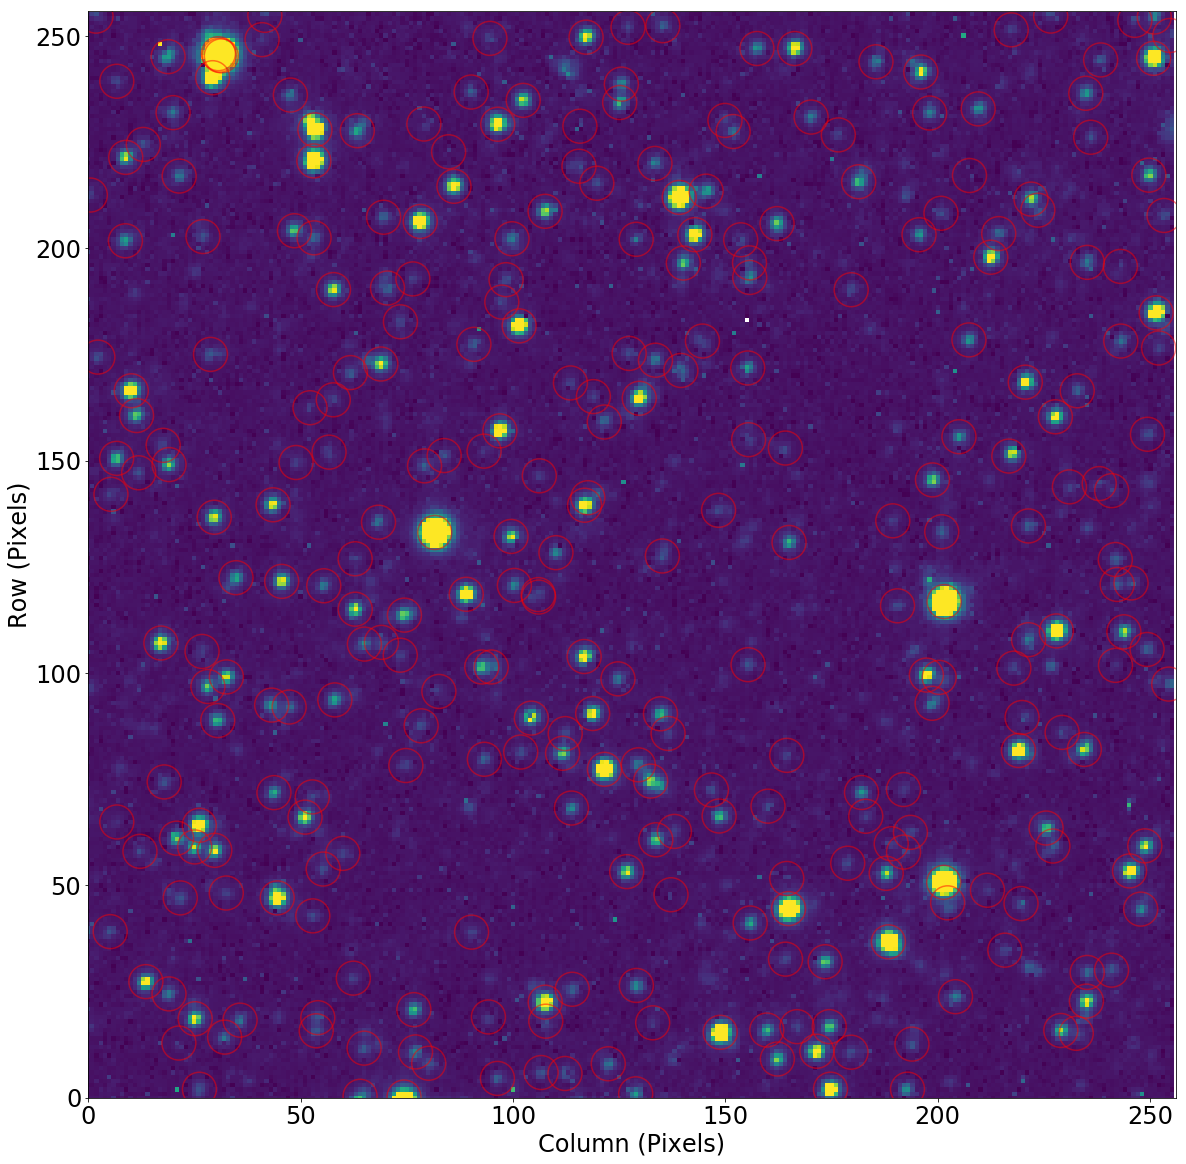

In [16]:
filename=workdir+lightlist[40]

scidata=neo.read_fitsdata(filename)
imstat=neo.imagestat(scidata,bpix)

mean, median, std = sigma_clipped_stats(scidata, sigma=3.0, iters=5)
daofind = DAOStarFinder(fwhm=2.0, threshold=5.*std)
sources = daofind(scidata - median)

neo.plot_image_wsource(scidata,imstat,3.0,50.0,sources)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=photap)
phot_table = aperture_photometry(scidata-median, apertures)

nstar=len(phot_table['aperture_sum'])
#for j in range(nstar):
#    print(j,phot_table['xcenter'][j],phot_table['ycenter'][j],phot_table['aperture_sum'][j])

## Batch process and extract photometry for all images  

In [6]:
pbar = tqdm_notebook(total=len(lightlist))  #Progress bar.
pool = mp.Pool(processes=nprocessor)  #How many threads to use.
results = [pool.apply_async(neo.photprocess, args=(workdir+lightlist[i],jddate[i],photap,bpix,),callback=barupdate)\
           for i in range(len(lightlist))]
photall = [p.get() for p in results]
pool.close()
pool.join()

In [12]:
## Tasks to clean up multiprocessing if it is aborted.  
#pool.close()
#pool.terminate()
#pool.join()

## Code to find frame transformations  


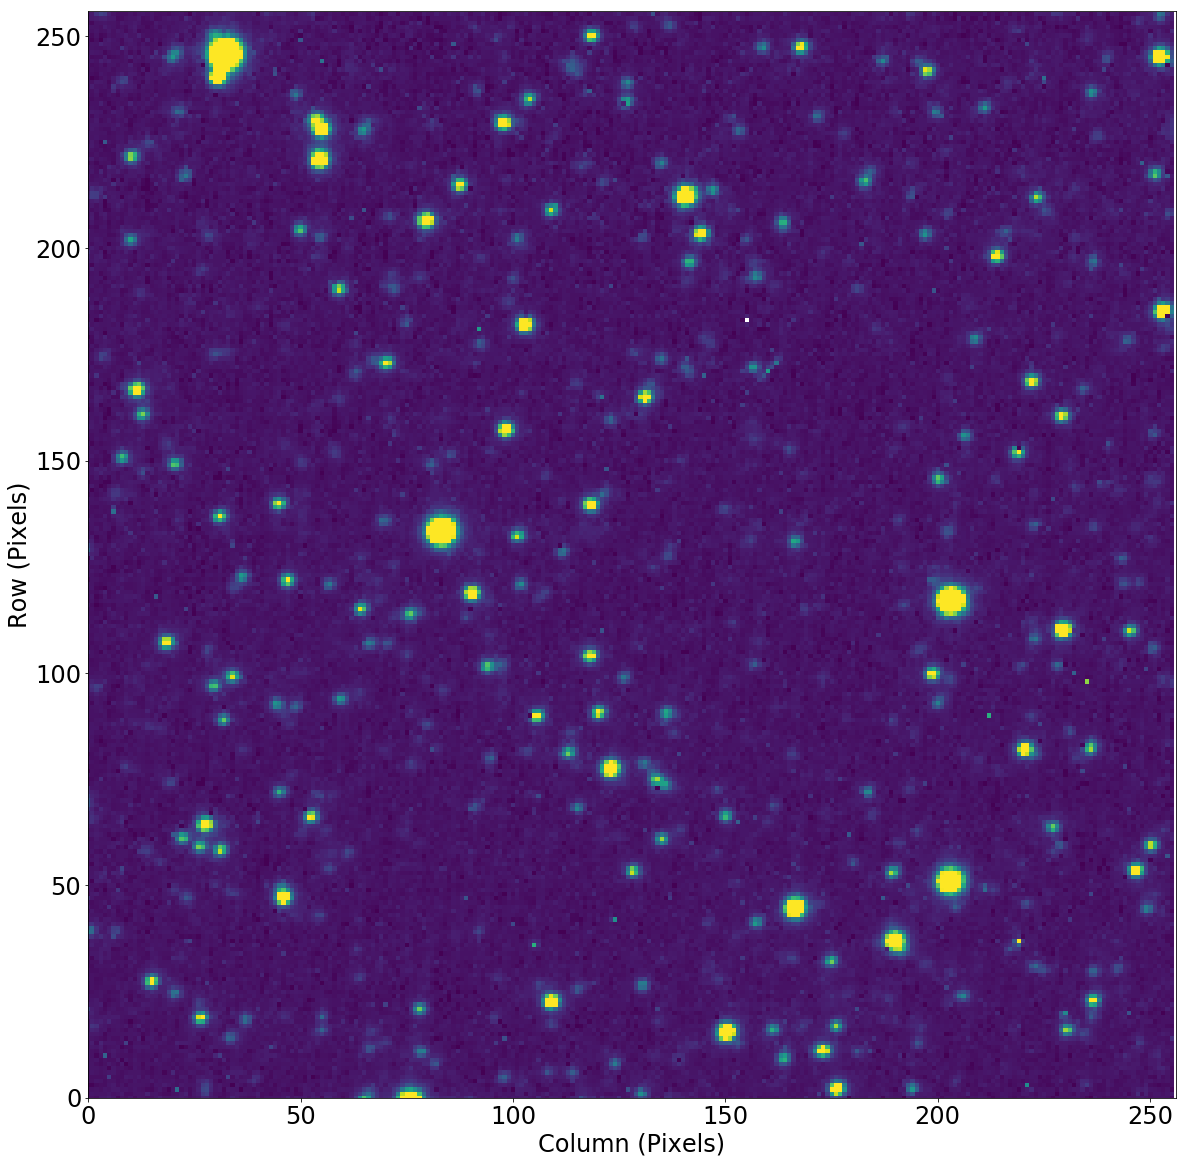

In [7]:
#Check for a good master
n1=int(len(lightlist)/2)
x=neo.read_fitsdata(photall[n1][5])
imstat=neo.imagestat(x,bpix)
neo.plot_image(x,imstat,3.0,50.0)

## Match Stars and calculate transformations to register frames

This routine is not great and needs work. You will see lots of warning messages barfed out.  Ignore for now.

In [9]:
nframe=len(np.array(photall[:]))
nmaster=int(len(lightlist)/2) #Master Frame
pbar = tqdm_notebook(total=nframe)  #Progress bar.
pool = mp.Pool(processes=24)  #How many threads to use.
results = [pool.apply_async(neo.calctransprocess, args=(np.array(photall[nmaster][0]['xcenter'][:]),\
           np.array(photall[nmaster][0]['ycenter'][:]),photall[nmaster][0]['aperture_sum'][:],\
           np.array(photall[i][0]['xcenter'][:]),np.array(photall[i][0]['ycenter'][:]),\
           photall[i][0]['aperture_sum'][:],),callback=barupdate)\
           for i in range(0,nframe)]
transall = [p.get() for p in results]
pool.close()
pool.join()

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Matching Failed


/home/rowe/Documents/python/NEOSSat/neossatlib.py:716: RuntimeWarning: invalid value encountered in long_scalars
  if votes[n1-1,0]/maxvote < 0.5:


Matching Failed


/home/rowe/Documents/python/NEOSSat/neossatlib.py:716: RuntimeWarning: invalid value encountered in long_scalars
  if votes[n1-1,0]/maxvote < 0.5:


## Clean up Image list

Images with poor transformations are now tossed.  These images probably produced all the warnings above.

In [10]:
exptime_c=[]
jddate_c=[]
transall_c=[]
photall_c=[]
lightlist_c=[]
nfig=len(photall)
cutlist=[]
for i in range(nfig):
    if (np.abs(1.0-transall[i][1][0][0] ) < 0.05) and (np.abs(1.0-transall[i][1][1][1]) < 0.05):
        exptime_c.append(exptime[i])
        jddate_c.append(jddate[i])
        transall_c.append(transall[i])
        photall_c.append(photall[i])
        lightlist_c.append(lightlist[i])
exptime=np.array(exptime_c)
jddate=np.array(jddate_c)
transall=transall_c.copy()
photall=photall_c.copy()
lightlist=lightlist_c.copy()

## Stacking Images  
 - not a very smart routine.  It will load all images into memory before calculating a median.. so beware.

In [11]:
from skimage import transform as tf #To manipulate images 

In [12]:
nfig=len(photall)
image_t=[]
for i in range(nfig):
    n1=np.copy(i)
    tform=tf.AffineTransform()
    matrix = tform.params.copy()

    matrix[0][0]=transall[n1][1][0][0] 
    matrix[0][1]=transall[n1][1][0][1]
    matrix[0][2]=transall[n1][0][0]

    matrix[1][0]=transall[n1][1][1][0] 
    matrix[1][1]=transall[n1][1][1][1]
    matrix[1][2]=transall[n1][0][1]
    
    if (np.abs(1.0-matrix[0][0]) < 0.05) and (np.abs(1.0-matrix[1][1]) < 0.05): #keep only sane transforms
        scidata=neo.read_fitsdata(photall[i][5])
        tform2 = tf.AffineTransform(matrix)
        image_t.append(tf.warp(scidata,tform2.inverse))

image_med=np.median([image_t[i]-np.median(image_t[i]) for i in range(len(image_t))],axis=0)
image_t=[]

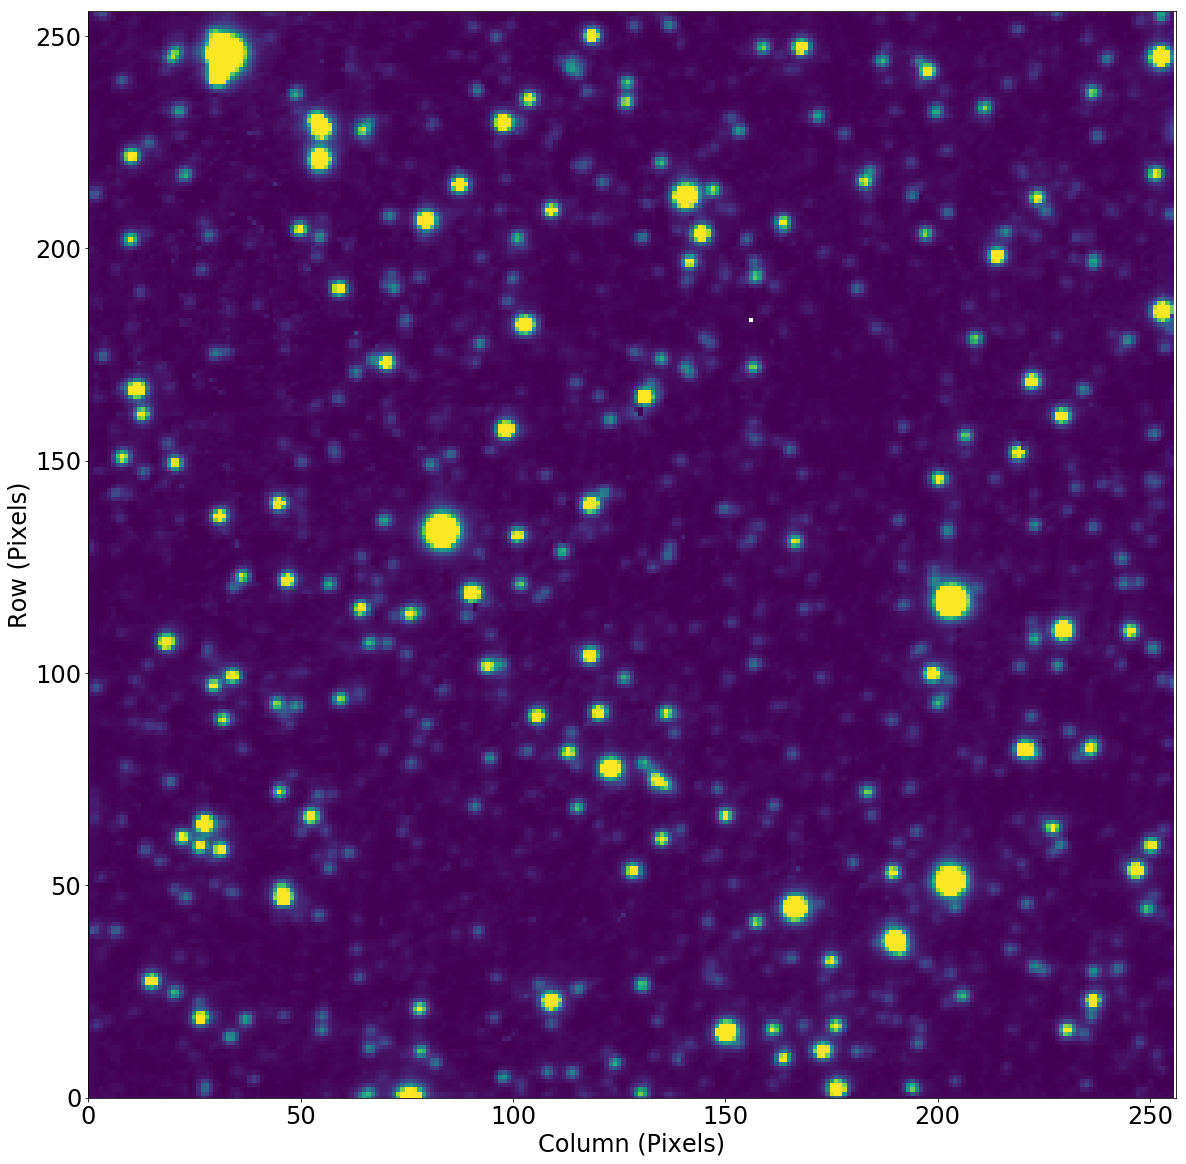

In [13]:
imstat=neo.imagestat(image_med,bpix)
#print(imstat)
neo.plot_image(image_med,imstat,1.0,50.0)

## Master Photometry List:

We now use the median stacked image to create our master star list.

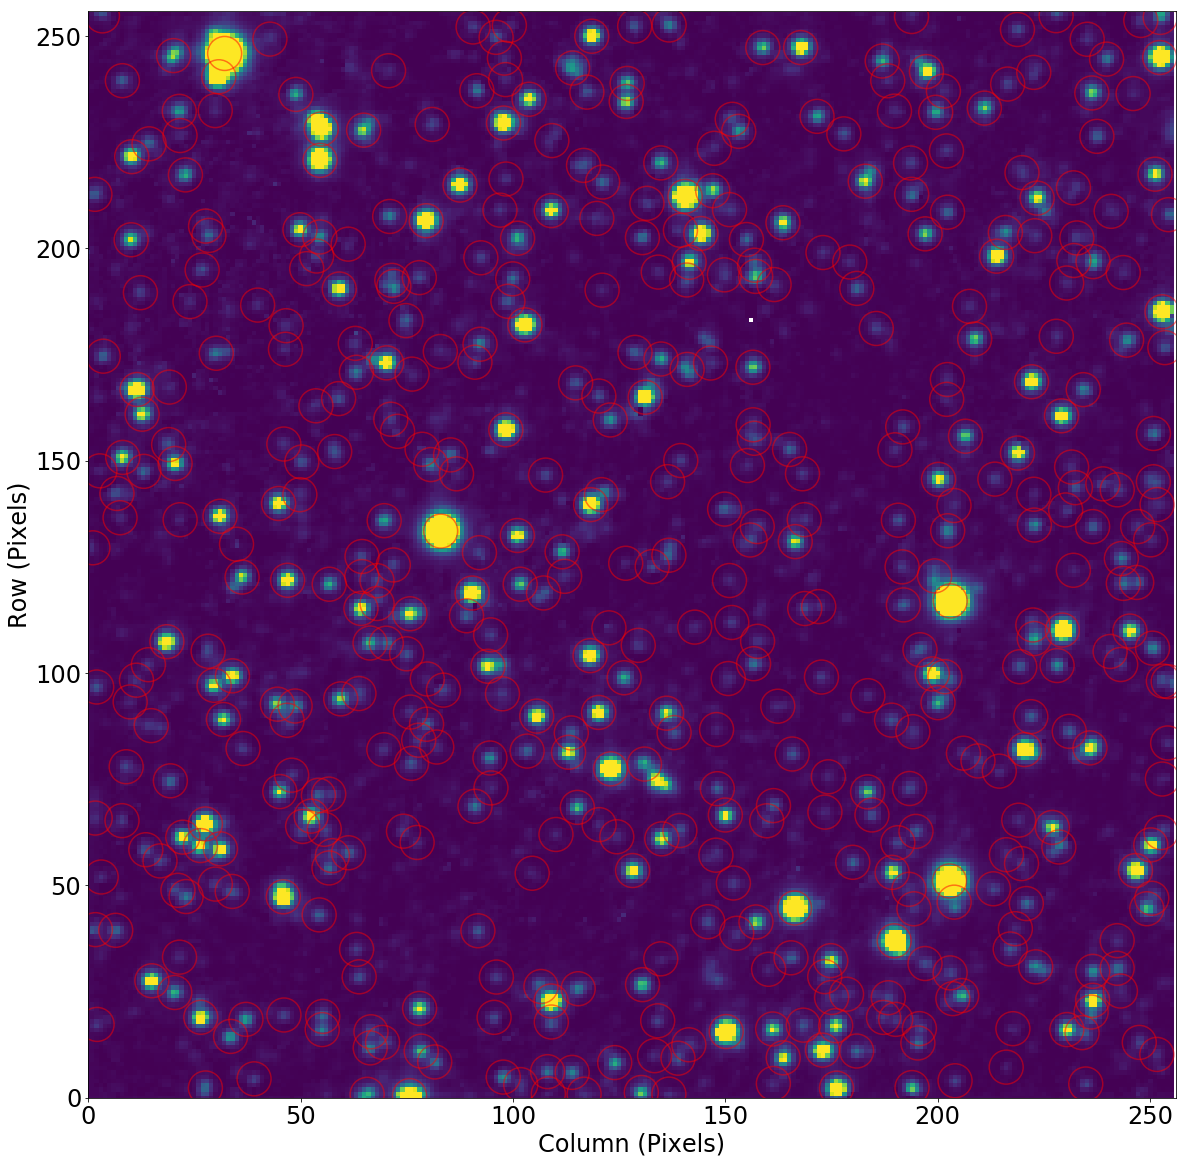

0 65.66050324342167 pix 0.8169915220040698 pix 13188.777100771596
1 75.63071986788104 pix 0.5130827104237252 pix 86369.63625923902
2 108.32425993866778 pix 0.9354216432169757 pix 688.121863009863
3 116.73587169501836 pix 0.8535915306806965 pix 2378.501413291639
4 130.2172043930588 pix 1.262578799365712 pix 11811.206065802027
5 136.707247227557 pix 0.8725032224441416 pix 1560.5197283136595
6 27.571118836833374 pix 2.316335890800542 pix 6568.667907558472
7 176.17112239631868 pix 2.273254875662147 pix 58578.37026948178
8 193.9564740971033 pix 2.4067119255641205 pix 11234.701798856899
9 101.81705759249576 pix 3.103380360356782 pix 3379.4563765407115
10 161.30412981384208 pix 3.368478552889812 pix 2121.8539685021324
11 234.86114299841708 pix 3.2535478828945457 pix 1991.568470890179
12 39.02976644345721 pix 4.463803625539401 pix 1975.453156606299
13 204.08807163071472 pix 4.0122454734630875 pix 2248.564603304547
14 97.69884599046364 pix 4.877514455807485 pix 7059.158898497808
15 108.13864568

324 78.59056219311056 pix 152.71323016982362 pix 1647.0616404990947
325 165.1243905404394 pix 152.6696804252849 pix 4865.311476901089
326 189.94012303389883 pix 152.58076385790451 pix 1381.572302300564
327 18.912071340357176 pix 153.81152431512132 pix 5581.9003241299715
328 46.03658240109798 pix 153.94236275308825 pix 1946.2283485232053
329 156.81512170503987 pix 155.29212092778667 pix 5548.165793323744
330 72.8221315072805 pix 156.93891063643215 pix 1684.5418488936225
331 206.54282844873106 pix 155.78001364123642 pix 13482.874088883173
332 250.80716040557667 pix 156.4256173644519 pix 5534.181245267868
333 98.30121403492674 pix 157.28910581311283 pix 59948.34470182758
334 191.7663495515082 pix 157.9788384799478 pix 2717.3929879965644
335 156.54706070212393 pix 158.473767621311 pix 3826.808659615973
336 71.22203832147754 pix 159.78808967898087 pix 3050.146039320134
337 122.89505008100186 pix 159.6046026389627 pix 9194.17330437462
338 229.1465902539859 pix 160.58720290829794 pix 37114.95

In [31]:
scidata=np.copy(image_med)
imstat=neo.imagestat(scidata,bpix)

mean, median, std = sigma_clipped_stats(scidata, sigma=3.0, iters=5)
daofind = DAOStarFinder(fwhm=2.0, threshold=3.*std)
sources = daofind(scidata - median)

#remove any poor entries, this is a manual process
#sources.remove_rows([41])

neo.plot_image_wsource(scidata,imstat,1.0,50.0,sources)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=photap)
phot_table = aperture_photometry(scidata-median, apertures)

nstar=len(phot_table['aperture_sum'])
for j in range(nstar):
    print(j,phot_table['xcenter'][j],phot_table['ycenter'][j],phot_table['aperture_sum'][j])

## Photometry

Using master Star list from median stack, get photometry for all individual frames.  The part of the processing is currently single thread.

Todo:
- phot4all needs to be rewritten to use multiple processors. 

In [18]:
photometry, photometry_jd=neo.get_master_phot4all(workdir,lightlist,jddate,transall,phot_table,photap,bpix)

## Photometric Corrections

Use PCA to remove/reduce instrumental signatures.

We first cut very faint stars by imposing a minimum flux. We can also exclude specific stars using IDs.  

In [19]:
minflux=2000 #only stars with a median flux above this level are included in PCA analysis 
idexclude=[] #stars to exclude from PCA analysis 
pcavec=neo.get_pcavec(photometry_jd,photometry,exptime,minflux=minflux,id_exclude=idexclude)

163 26
nbad 0
bad/exclude list: []


## Display PCA vectors

Plot PCA vectors to see which ones look good.

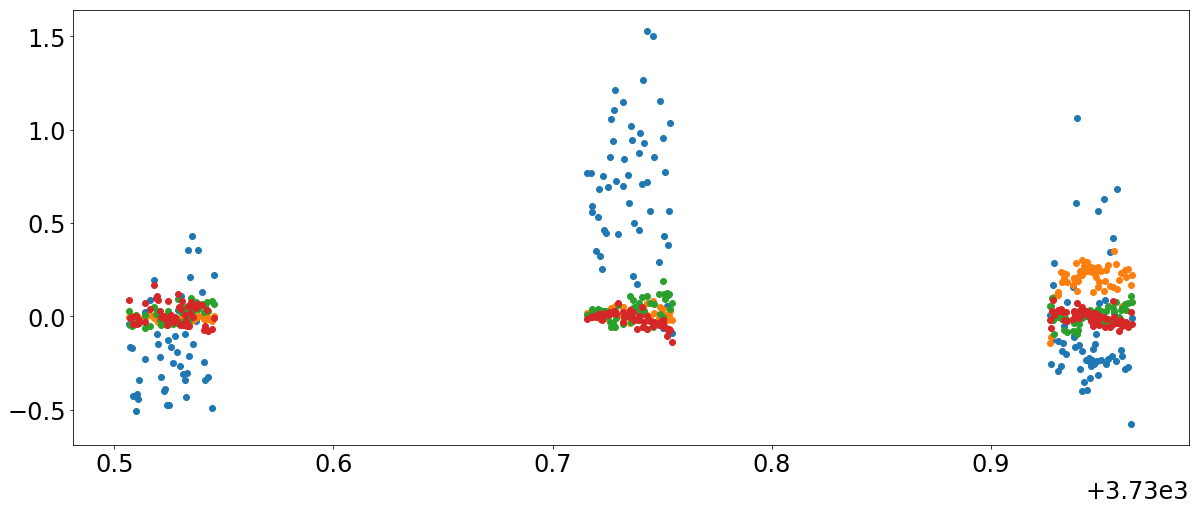

In [23]:
plt.figure(figsize=(20,8)) #adjust size of figure
#plt.axis([3750.55,3750.8,0.75,1.25])
jj=[0,1,2,3] #which vectors to display. 
for j in jj:
    plt.scatter(photometry_jd-2454900,pcavec[:,j])
plt.show()

In [29]:
np.min(photometry_jd[icut==0]-2454900)

3730.5069450698793

[ 0.99893068 -0.00656202  0.01478874]
[ 0.99893068 -0.00656202  0.01478874]
[ 0.99893068 -0.00656202  0.01478874]


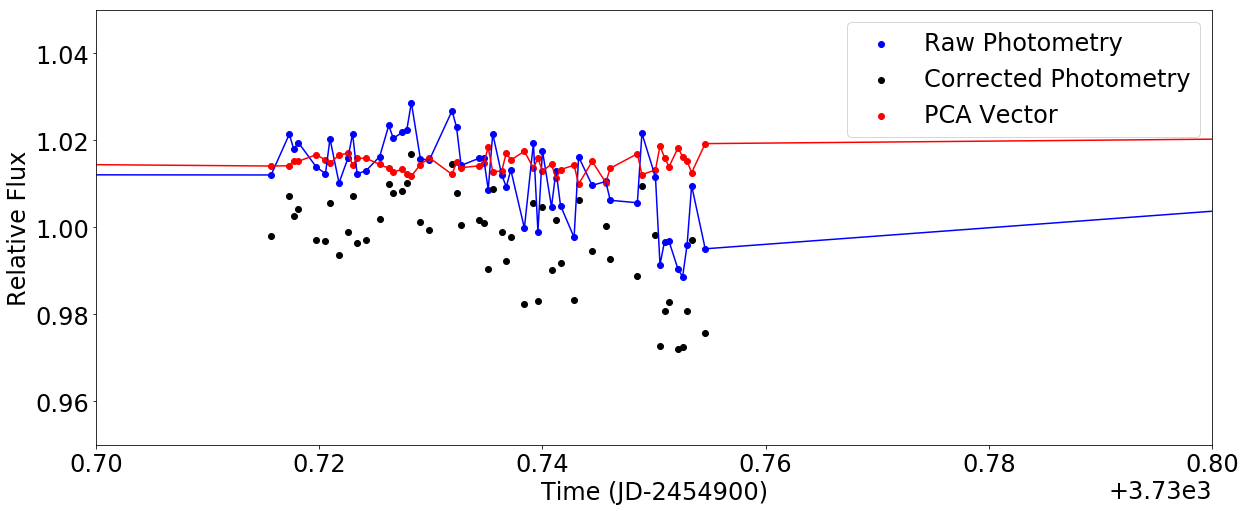

In [38]:
plt.figure(figsize=(20,8)) #adjust size of figure

plt.axis([3730.7,3730.8,0.95,1.05])
plt.xlabel('Time (JD-2454900)')
plt.ylabel('Relative Flux')

npca=2 #number of PCA vectors to use
jj=[490]

nspl=len(photometry_jd) #number of samples (time stamps)
ii=0
for j in jj:
    ii=ii+1
    #Get a lightcurve 
    phot1=np.array([photometry[i][j]['aperture_sum']/exptime[i] for i in range(nspl)])
    #Get PCA corrections + corrected photometry
    corflux, median, ans, icut = neo.pca_photcor(phot1,pcavec,npca,icut3=-1)
    #median scale original photometry
    phot1=phot1/median
    
    #make plots 
    plt.plot(photometry_jd[icut==0]-2454900,phot1[icut==0]+0.02*ii,c='blue')
    plt.scatter(photometry_jd[icut==0]-2454900,phot1[icut==0]+0.02*ii,c='blue',label='Raw Photometry')
    plt.scatter(photometry_jd[icut==0]-2454900,corflux[icut==0],c='black',label='Corrected Photometry')
    #bin_t,bin_f=neo.bindata(photometry_jd-2454900,corflux,100/(24*60))
    #plt.scatter(bin_t,bin_f)
    pcamodel=neo.pca_model(ans.x,pcavec)
    plt.plot(photometry_jd[icut==0]-2454900,pcamodel[icut==0]+0.02*ii,c='red')
    plt.scatter(photometry_jd[icut==0]-2454900,pcamodel[icut==0]+0.02*ii,c='red',label='PCA Vector')

plt.legend(loc='upper right')
plt.show()
#plt.savefig("WASP-33_PCA_correction.pdf")

In [39]:
medexptime=np.median(exptime)
for j in [65]:
    #print(j)
    
    phot1=np.array([photometry[i][j]['aperture_sum']/exptime[i] for i in range(nspl)])
    if math.isnan(np.sum(phot1))==False:  #Require valid data
        phot1=phot1*medexptime
        icut=neo.cutoutliers(phot1)
        icut2=neo.sigclip(phot1,icut)
        icut=icut+icut2
        phot1=neo.replaceoutlier(phot1,icut)
    
        pars=np.array([np.median(phot1),0.0,0.0])
        ans=op.least_squares(neo.pca_func,pars,args=[phot1,pcavec,icut])
        corflux=phot1-neo.pca_model(ans.x,pcavec)+np.median(phot1)

    
        meanf=np.median(corflux)
        if meanf>0:
            mag=-2.5*np.log10(meanf/exptime[j])
            std=np.std(corflux/np.median(corflux))
            print(mag,std)

-6.726432450679919 0.03491178766841699


In [40]:
print(len(photometry[0]))
print(len(photometry))

508
163


## Scatter Plot

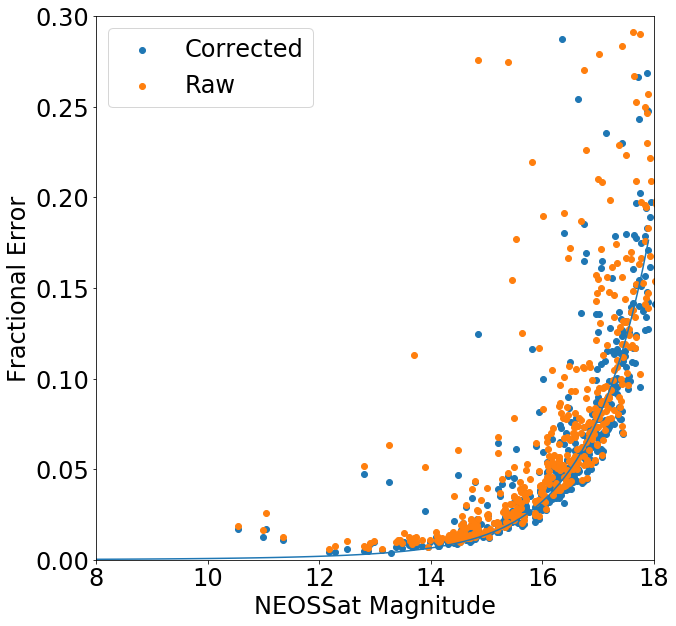

In [41]:
zmag=21.96
readnoise=8.0
npca=len(photometry[0]) #number of light curves
medexptime=np.median(exptime)
meanmag=[]
scatter=[]
scatter_raw=[]
for j in range(npca):
    #print(j)
    
    phot1=np.array([photometry[i][j]['aperture_sum']/exptime[i] for i in range(nspl)])
    if math.isnan(np.sum(phot1))==False:  #Require valid data
        phot1=phot1*medexptime
        icut=neo.cutoutliers(phot1)
        icut2=neo.sigclip(phot1,icut)
        icut=icut+icut2
        phot1=neo.replaceoutlier(phot1,icut)
    
        #get PCA model
        for i in range(3):
            pars=np.array([np.median(phot1),0.0,0.0])
            ans=op.least_squares(neo.pca_func,pars,args=[phot1,pcavec,icut])
            #print(ans.x)
            corflux=phot1-neo.pca_model(ans.x,pcavec)+np.median(phot1)
            icut2=neo.cutoutliers(corflux)
            icut=icut+icut2

        meanf=np.median(corflux[icut==0])
        if meanf>0:
            mag=-2.5*np.log10(meanf/medexptime)+zmag
            std=np.std(corflux[icut==0]/np.median(corflux[icut==0]))
            meanmag.append(mag)
            scatter.append(std)
            std2=np.std(phot1[icut==0]/np.median(phot1[icut==0]))
            scatter_raw.append(std2)
            
plt.figure(figsize=(10,10))
plt.axis([8.0,18.0,0.0,0.3])
plt.scatter(meanmag,scatter,label='Corrected')
plt.scatter(meanmag,scatter_raw,label='Raw')

xplot=[]
yplot=[]
for mag in np.arange(8,18,0.1):
    meanf=np.power(10,(zmag-mag)/2.5)*medexptime
    shotnoise=np.sqrt(meanf*gain)/(meanf*gain)
    detectnoise=np.sqrt(np.pi*photap*photap)*(readnoise+0.2*medexptime+1.05*medexptime)/(meanf*gain)
    predictnoise=np.sqrt(shotnoise*shotnoise+detectnoise*detectnoise)
    xplot.append(mag)
    yplot.append(predictnoise)
    
plt.plot(xplot,yplot)


plt.xlabel('NEOSSat Magnitude')
plt.ylabel('Fractional Error')
plt.legend(loc='upper left')
#plt.yscale('log')
plt.show()

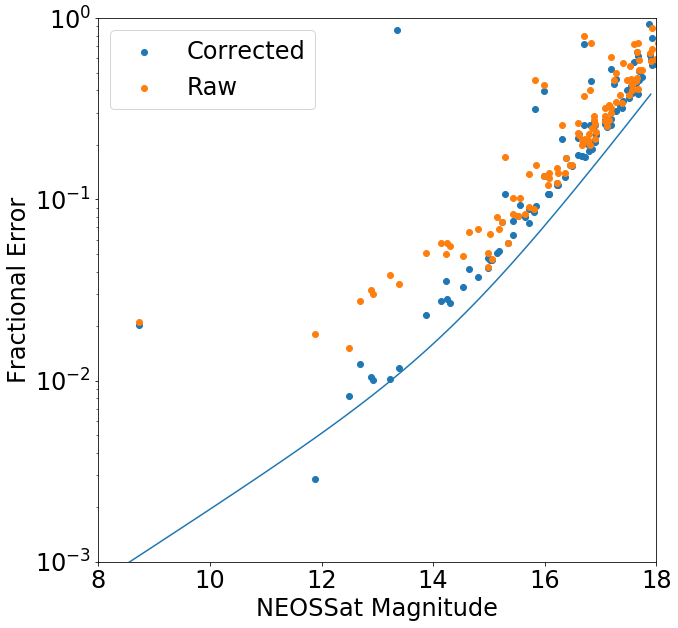

In [125]:
plt.figure(figsize=(10,10))
plt.axis([8.0,18.0,0.001,1.0])
plt.scatter(meanmag,scatter,label='Corrected')
plt.scatter(meanmag,scatter_raw,label='Raw')

xplot=[]
yplot=[]
for mag in np.arange(8,18,0.1):
    meanf=np.power(10,(zmag-mag)/2.5)*medexptime
    shotnoise=np.sqrt(meanf*gain)/(meanf*gain)
    detectnoise=np.sqrt(np.pi*photap*photap)*(readnoise+0.2*medexptime+1.05*medexptime)/(meanf*gain)
    predictnoise=np.sqrt(shotnoise*shotnoise+detectnoise*detectnoise)
    xplot.append(mag)
    yplot.append(predictnoise)
    
plt.plot(xplot,yplot)


plt.xlabel('NEOSSat Magnitude')
plt.ylabel('Fractional Error')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()
#plt.savefig("AUMic_magscatter.pdf")